In [12]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,classification_report
import itertools

import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import ImageFilter,ImageEnhance
from tensorflow.keras.optimizers import Adam

In [13]:
base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')



imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}



lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [14]:
skin_df = pd.read_csv("C:/Users/Annu/Desktop/Sem 4/HAM10000_metadata.csv")


skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [15]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/Annu/Desktop/Sem 4\HAM10000_images_pa...,Benign keratosis-like lesions,2


<AxesSubplot:>

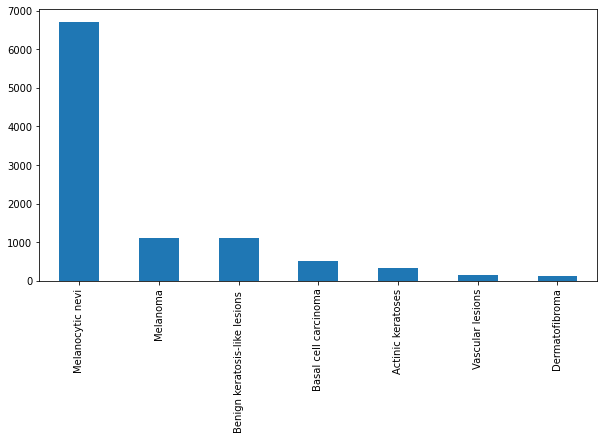

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [17]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((150,100))))

In [18]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
rgb_info_df = skin_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df


,Red_mean,Green_mean,Blue_mean,Gray_mean
0,1.132182,0.882490,0.985328,184.367778
1,1.114017,0.884627,1.001356,176.967156
2,1.179278,0.861725,0.958997,181.514156
3,1.184913,0.863453,0.951634,165.171244
4,1.124242,0.892031,0.983727,188.319978
...,...,...,...,...
10010,1.118374,0.932463,0.949163,181.813756
10011,1.120018,0.936103,0.943880,163.461667
10012,1.098935,0.948105,0.952960,200.158978
10013,1.114622,0.909954,0.975425,169.597600


In [19]:
for c_col in rgb_info_df.columns:
    skin_df[c_col] = rgb_info_df[c_col].values 
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)
x_train = x_train.reshape(x_train.shape[0], *(100, 150, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 150, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 150, 3))
input_shape = (100, 150, 3)
num_classes = 7
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet


base_model = MobileNet(weights="imagenet", include_top=False , input_shape=(100, 150, 3))

In [20]:
from keras.models import Sequential , Model
from keras.layers import Dropout , GlobalAveragePooling2D
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 50, 75, 32)        0   

In [21]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)
epochs = 50
batch_size = 32

history = model.fit(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Epoch 1/50
225/225 [==============================] - 374s 2s/step - loss: 1.4211 - accuracy: 0.6010 - val_loss: 0.9469 - val_accuracy: 0.7020
Epoch 2/50
225/225 [==============================] - 451s 2s/step - loss: 0.7180 - accuracy: 0.7716 - val_loss: 0.9249 - val_accuracy: 0.7469
Epoch 3/50
225/225 [==============================] - 434s 2s/step - loss: 0.6154 - accuracy: 0.7903 - val_loss: 0.9787 - val_accuracy: 0.7007
Epoch 4/50
225/225 [==============================] - 389s 2s/step - loss: 0.5456 - accuracy: 0.8003 - val_loss: 0.7299 - val_accuracy: 0.7569
Epoch 5/50
225/225 [==============================] - 511s 2s/step - loss: 0.4390 - accuracy: 0.8398 - val_loss: 0.7119 - val_accuracy: 0.7818
Epoch 6/50
225/225 [==============================] - 499s 2s/step - loss: 0.4222 - accuracy: 0.8491 - val_loss: 0.6120 - val_accuracy: 0.7830
Epoch 7/50
225/225 [==============================] - 1070s 5s/step - loss: 0.3788 - accuracy: 0.8626 - val_loss: 0.6906 - val_accuracy: 0.794

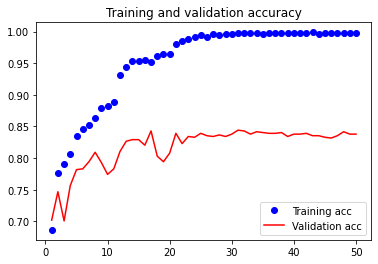

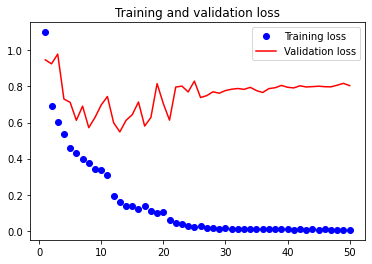

In [23]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show() 

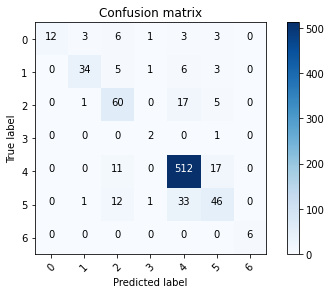

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Y_pred = model.predict(x_validate)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

Y_true = np.argmax(y_validate,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


plot_confusion_matrix(confusion_mtx, classes = range(7))

In [26]:

categories = ['Actinic keratoses', 'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi',
              'Melanoma', 
              'Vascular lesions']

from sklearn.metrics import classification_report

#report = classification_report(Y_true, Y_pred, target_names=categories)
report = classification_report(Y_true, Y_pred, target_names=Y_pred_classes)
print(report)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [28]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_validate)
predictions = np.array(list(map(lambda x: np.argmax(x), x_validate)))
categories = ['Actinic keratoses', 'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi',
              'Melanoma', 
              'Vascular lesions']

CMatrix = pd.DataFrame(confusion_matrix(Y_pred, predictions), columns=categories, index =categories)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);


ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [29]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

26/26 [==============================] - 8s 284ms/step - loss: 0.8041 - accuracy: 0.8379
Validation: accuracy = 0.837905  ;  loss_v = 0.804071
Test: accuracy = 0.860210  ;  loss = 0.724468
